#Реализация нейронной сети
@Василий Гурьев

#Imports

In [0]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import pickle
from sklearn.metrics import classification_report, f1_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
import time
warnings.filterwarnings('ignore')

%matplotlib inline

#Defs

##Layers

###conv_block

In [0]:
def conv_block(x, kernel_size, input_size, output_size, name): # свёрточный блок
  kernel_shape = [kernel_size, input_size, output_size] # форма ядра свёртки

  weights = tf.Variable(tf.truncated_normal(kernel_shape, stddev=0.03), name=f'{name}_w') # веса
  bias = tf.Variable(tf.truncated_normal([output_size], stddev=0.01), name=f'{name}_b') # смещение

  out = tf.nn.conv1d(x, weights, [1, 1, 1], padding='SAME', name=f'{name}_c') + bias # свёртка

  # out = tf.nn.dropout(x=out, rate=DROPOUT, name=f'{name}_d') # дропаут
  out = tf.nn.relu(out, name=f'{name}_activation') # активация
  return tf.add(out, x, name=f'{name}_a') # skip connection

###dense_block

In [0]:
def dense_block(x, input_size, output_size, name): # полносвязный слой
  weights = tf.Variable(tf.truncated_normal([input_size, output_size], stddev=0.03), name=f'{name}_w') # веса
  bias = tf.Variable(tf.truncated_normal([output_size], stddev=0.01), name=f'{name}_b') # смешения
  return tf.add(tf.matmul(x, weights, name=f'{name}_m'), bias, name=f'{name}_a') # возвращаем слой

###build_graph

In [0]:
def build_graph(tblock=3, sblock=3, tkernal=3, skernal=3): # строим граф
  x = tf.placeholder(tf.int32, [None, SENT_LEN, TOKEN_LEN], name='x') # входной плейсхолдер
  y = tf.placeholder(tf.float32, [None, SENT_LEN, TAG_DIM], name='y') # выходной плейсхолдер
  x_shaped = tf.reshape(x, [-1, TOKEN_LEN], name='x_shaped') # переход на уровень токенов
  embedding_table = tf.Variable(tf.random_uniform([CHAR_DIM, EMBED_DIM]), name='embedding_table') # задание начальных значений эмбеддинга
  embedding = tf.nn.embedding_lookup(embedding_table, x_shaped, name='embedding') # эмбеддинг-слой
  conv = embedding
  for i in range(tblock): # добавляем заданное количество
    conv = conv_block(conv, tkernal, EMBED_DIM, EMBED_DIM, name=f'TBLOCK_{i}') # свёрточных блоков
  pooling = tf.nn.pool(conv, [TOKEN_LEN], 'MAX', 'SAME', strides=[TOKEN_LEN], name='pooling') # слой глобального макспулинга
  pooling = tf.reshape(pooling, [-1, SENT_LEN, EMBED_DIM], name='reshape') # переход на уровень предложений
  conv = pooling
  for i in range(sblock): # добавляем заданное количество
    conv = conv_block(conv, skernal, EMBED_DIM, EMBED_DIM, name=f'SBLOCK_{i}') # свёрточных блоков
  y_ = tf.nn.sigmoid(dense_block(conv, EMBED_DIM, TAG_DIM, name='DENSE'), name='y_')
  # добавляем полносвязный слой и функцию активации
  return x, y, y_

##Losses and metrics

###cross_entropy

In [0]:
def cross_entropy(y_true, y_pred): # кросс-энтропия по оси 2
  return -tf.reduce_mean(tf.reduce_sum(y_true * tf.log(y_pred) + (1 - y_true) * tf.log(1 - y_pred), axis=2))

###accuracy

In [0]:
def accuracy(y_true, y_pred): # точность
  return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float64))

###plot_acc

In [0]:
def plot_acc(history): # печать графика точности
  plt.figure(figsize=(18, 6))
  plt.plot(history['train_acc'], label='train_acc')
  plt.plot(history['val_acc'], label='val_acc')
  plt.xlabel('epochs')
  plt.ylabel('acc')
  plt.legend()
  plt.show()

###plot_loss

In [0]:
def plot_loss(history): # печать графика потерь
  plt.figure(figsize=(18, 6))
  plt.plot(history['train_loss'], label='train_loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

##Text

In [0]:
def text_to_sentences(text): # режем текст на предложения
  return re.findall(r'["А-ЯЁA-Z].+?(?:["a-zа-яё]{2}|["A-ZА-ЯЁ]{2})(?:\.+|\!+|\?+)', text.replace('\n', ' '))


def sentence_to_words(sentence): # режим предложения на на токены
  return re.findall(r'[A-Za-zА-ЯЁа-яё0-9-]+', sentence.lower())

#Loading

In [0]:
drive.mount('/content/gdrive') # подключаем диск
os.chdir('/content/gdrive/My Drive/Colab Notebooks/NNDW') # задаём рабочую директорию

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
npz = np.load('data/dataset_2002.npz') # загрузка векторизованных входных и выходных данных
inputs, labels = [npz[item] for item in npz]

In [0]:
SENT_LEN = inputs.shape[1] # максимальная длина предложения (включая токены начала и конца)
TOKEN_LEN = inputs.shape[2] # максимальная длина токена (включая пробелы начала и конца)
CHAR_DIM = 33 # размер словаря
TAG_DIM = labels.shape[2] # количество классов
EMBED_DIM = 128 # размер векторного представления индексов букв

In [0]:
n = int(len(inputs) * 0.8) # доля обучающей выборки
train_inputs, test_inputs = np.split(inputs.astype('int32'), [n], axis=0) # входные тензоры
train_labels, test_labels = np.split(labels.astype('float64'), [n], axis=0) # выходные тензоры

In [0]:
grammemes = pd.read_csv('dicts/grammemes.csv') # словарь граммем

In [0]:
with open('data/extra_test.txt', 'r') as f: # загружаем дополнительный датасет
  text = f.read()

In [0]:
text # предложения повышенной сложности для дополнительной проверки

'Крылышкуя золотописьмом\nТончайших жил,\nКузнечик в кузов пуза уложил\nПрибрежных много трав и вер.\nСорок сорок глядели на гладь.\nКосой косой косил косой.\n'

In [0]:
extra_data = pd.DataFrame({
    'sentence': text_to_sentences(text)
})
extra_data

,sentence
0,"Крылышкуя золотописьмом Тончайших жил, Кузнечи..."
1,Сорок сорок глядели на гладь.
2,Косой косой косил косой.


In [0]:
extra_data['words'] = extra_data.sentence.apply(sentence_to_words)
extra_data

,sentence,words
0,"Крылышкуя золотописьмом Тончайших жил, Кузнечи...","[крылышкуя, золотописьмом, тончайших, жил, куз..."
1,Сорок сорок глядели на гладь.,"[сорок, сорок, глядели, на, гладь]"
2,Косой косой косил косой.,"[косой, косой, косил, косой]"


In [0]:
symbols = {chr(ord('а')+i): i + 1 for i in range(32)} # словарь символов
symbols['ё'] = 33

In [0]:
# векторизация дополнительных входных данных 
extra_inputs = np.zeros((len(extra_data), SENT_LEN, TOKEN_LEN))
for i, sentence in enumerate(extra_data.words):
  for j, token in enumerate(sentence):
    for k, char in enumerate(token):
      extra_inputs[i, j+1, k+1] = symbols[char]

#Network

In [0]:
global_step = tf.Variable(0, trainable=True, name='global_step') #
starter_learning_rate = 0.006 # задаём начальный шаг обучения
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 5000, 0.6, staircase=False)
# задаём функцию постепенного уменьшения шага обучения

EPOCHS = 60 # количество эпох
BATCH_SIZE = 200 # размер пакета
VAL_SPLIT = 0.2 # доля выборки для валидации
TRAIN_SIZE = int((1 - VAL_SPLIT) * len(train_labels) / BATCH_SIZE) # количество экземпляров обучающей выборки
VAL_SIZE = int(VAL_SPLIT * len(train_labels) / BATCH_SIZE) # количество экземпляров проверочной выборки
TEST_SIZE = int(len(test_labels) / BATCH_SIZE) # количество экземпляров тестовой выборки

In [0]:
# создание плейсхолдеров входа и выхода и итераторов обучающего и тестовых датасетов

train_x = tf.placeholder(train_inputs.dtype, train_inputs.shape, name='train_x')
train_y = tf.placeholder(train_labels.dtype, train_labels.shape, name='train_y')
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE)
train_iterator = train_dataset.make_initializable_iterator()
next_train = train_iterator.get_next()

test_x = tf.placeholder(test_inputs.dtype, test_inputs.shape, name='text_x')
test_dataset = tf.data.Dataset.from_tensor_slices(test_x)
test_dataset = test_dataset.batch(1)
test_iterator = test_dataset.make_initializable_iterator()
next_test = test_iterator.get_next()

extra_x = tf.placeholder(extra_inputs.dtype, extra_inputs.shape, name='extra_x')
extra_dataset = tf.data.Dataset.from_tensor_slices(extra_x)
extra_dataset = extra_dataset.batch(1)
extra_iterator = extra_dataset.make_initializable_iterator()
next_extra = extra_iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


##Training

In [0]:
x, y, y_ = build_graph(5, 5, 5, 3) # строим граф с заданным количеством блоков и размерами ядер свёрток

y_clipped = tf.clip_by_value(y_, 1e-5, 1 - 1e-5) # подрезаем выходные данные
loss = cross_entropy(y, y_clipped) # задаём функцию потерь
acc = accuracy(y, y_) # задаём метрику (точность)

optimiser = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(loss, global_step=global_step)
# задаём оптимизатор
saver = tf.train.Saver() # задаём сейвер
history = {
    'train_loss': [0] * EPOCHS,
    'train_acc': [0] * EPOCHS,
    'val_loss': [0] * EPOCHS,
    'val_acc': [0] * EPOCHS,
    'learning_rate': [0] * EPOCHS
    } # словарь истории обучения

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



__________________________________________________	epoch:	time:	learning_rate:	train_loss:	train_acc:	val_loss:	val_acc:
||||||||||||||||||||||||||||||||||||||||||||||||||	1	94	0.00586		4.535		0.9727		2.1779		0.9852	
||||||||||||||||||||||||||||||||||||||||||||||||||	2	91	0.0056		1.4858		0.9906		0.9811		0.9941	
||||||||||||||||||||||||||||||||||||||||||||||||||	3	90	0.00535		0.9179		0.9945		0.8201		0.9952	
||||||||||||||||||||||||||||||||||||||||||||||||||	4	90	0.00511		0.7526		0.9956		0.7419		0.9957	
||||||||||||||||||||||||||||||||||||||||||||||||||	5	88	0.00488		0.6713		0.9962		0.6316		0.9964	
||||||||||||||||||||||||||||||||||||||||||||||||||	6	88	0.00466		0.6213		0.9965		0.636		0.9963	
||||||||||||||||||||||||||||||||||||||||||||||||||	7	88	0.00445		0.5861		0.9967		0.5663		0.9968	
||||||||||||||||||||||||||||||||||||||||||||||||||	8	88	0.00425		0.5594		0.9968		0.5562		0.9969	
||||||||||||||||||||||||||||||||||||||||||||||||||	9	88	0.00406		0.5396		0.997		0.546		0.997	
|||||||||||

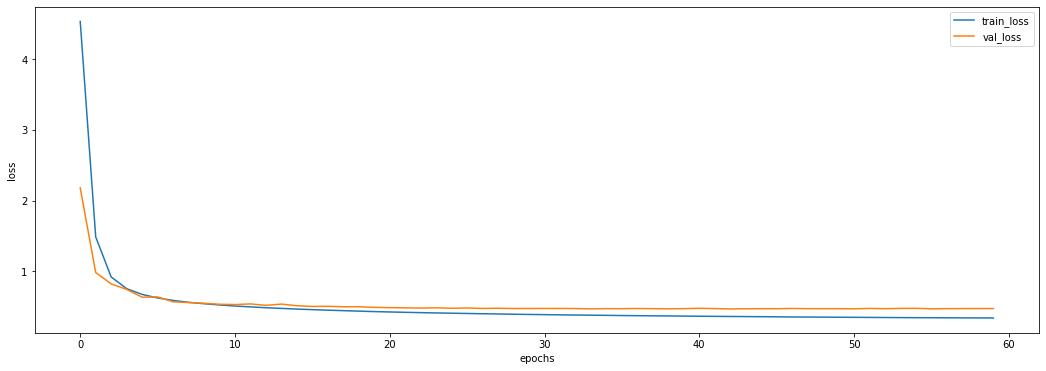

last val acc: 0.9976


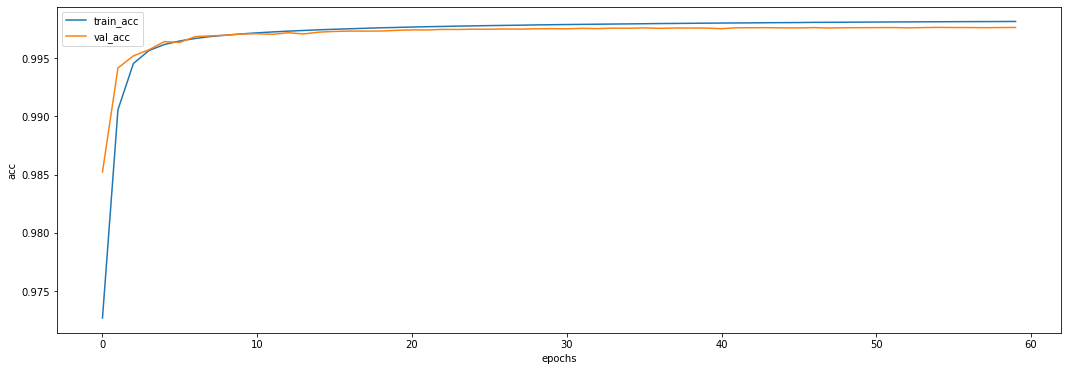

In [0]:
with tf.Session() as sess: # открываем сессию
  sess.run(tf.global_variables_initializer()) # инициализацируем переменные
  
  print('\n'+'_' * 50 + '\tepoch:\ttime:\tlearning_rate:\ttrain_loss:\ttrain_acc:\tval_loss:\tval_acc:')
  # печатаем шапку таблицы истории обучения
  
  for epoch in range(EPOCHS): # для каждой эпохи
    start = time.time() # запоминаем время её начала
    progress = 0 # сбрасываем прогресс-бар
    sess.run(train_iterator.initializer, feed_dict={train_x: train_inputs, train_y: train_labels})
    # инициализацируем итератор обучающего датасета
    
    for batch in range(TRAIN_SIZE): # из обучающей выборки
      batch_x, batch_y = sess.run(next_train) # получаем новый пакет данных
      _, train_loss, train_acc, lr = sess.run([optimiser, loss, acc, learning_rate], feed_dict={x: batch_x, y: batch_y})
      # оптимизируем параметры сети по по пакету и получаем потерю, метрику и текущий шаг обучения
      history['train_loss'][epoch] += train_loss / TRAIN_SIZE
      history['train_acc'][epoch] += train_acc / TRAIN_SIZE
      history['learning_rate'][epoch] += lr / TRAIN_SIZE
      # добавляем их в историю
      
      if 50 * batch / TRAIN_SIZE > progress: # каждые 50 пакетов
        print('|', end='') # обновляем прогресс-бар
        progress += 1      
    
    for batch in range(VAL_SIZE): # из проверочной выборки
      batch_x, batch_y = sess.run(next_train) # получаем новый пакет данных
      val_loss, val_acc = sess.run([loss, acc], feed_dict={x: batch_x, y: batch_y}) # считаем потерю и точность
      history['val_loss'][epoch] += val_loss / VAL_SIZE
      history['val_acc'][epoch] += val_acc / VAL_SIZE
      # добавляем их в историю
    
    stats = f'\t{epoch + 1}' + \
            f'\t{round(time.time() - start)}' + \
            f'\t{round(history["learning_rate"][epoch], 5)}\t' + \
            f'\t{round(history["train_loss"][epoch], 4)}\t' + \
            f'\t{round(history["train_acc"][epoch], 4)}\t' + \
            f'\t{round(history["val_loss"][epoch], 4)}\t' + \
            f'\t{round(history["val_acc"][epoch], 4)}\t'
    print(stats) # печатаем статистику
  print('last val loss:', round(history['val_loss'][-1], 4)) # печатаем конечную потерю на проверочной выборке
  plot_loss(history) # печатаем график потерь
  print('last val acc:', round(history['val_acc'][-1], 4)) # печатаем конечную точность на проверочной выборке
  plot_acc(history) # печатаем график точности
  
  sess.run(test_iterator.initializer, feed_dict={test_x: test_inputs})
  # инициализируем итератор тестовой выборки
  y_pred = np.vstack([sess.run(y_, feed_dict={x: sess.run(next_test)}) for _ in range(len(test_inputs))])
  # получаем предсказания на тестовой выборке

  sess.run(extra_iterator.initializer, feed_dict={extra_x: extra_inputs})
  # инициализируем итератор дополнительного датасета
  extra_y = np.vstack([sess.run(y_, feed_dict={x: sess.run(next_extra)}) for _ in range(len(extra_inputs))])
  # получаем предсказания на дополнительном датасете

  saver.save(sess, "checkpoints/model.ckpt") # сохранение модели

np.savez_compressed('predictions/y_pred_2002', y_pred) # сохранение тестовых предсказаний
np.savez_compressed('predictions/extra_y', extra_y) # сохранение дополнительных предсказаний

##Testing

In [0]:
y_pred = np.load('predictions/y_pred_2002.npz')['arr_0'].round() # загружаем тестовые предсказания

###Точность на уровне граммем

In [0]:
round((test_labels == y_pred).mean(), 4)

0.9975

###F1-score на уровне граммем

In [0]:
for i in range(len(grammemes)):
  print(f'{grammemes.description[i]}\n{grammemes.grammeme[i]}')
  print(classification_report(test_labels.reshape((-1, TAG_DIM))[:, i], y_pred.reshape((-1, TAG_DIM))[:, i]), end='\n\n')

существительное
NOUN
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    728682
         1.0       0.99      0.98      0.99    174422

    accuracy                           0.99    903104
   macro avg       0.99      0.99      0.99    903104
weighted avg       0.99      0.99      0.99    903104


полное прилагательное
ADJF
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    845000
         1.0       0.98      0.98      0.98     58104

    accuracy                           1.00    903104
   macro avg       0.99      0.99      0.99    903104
weighted avg       1.00      1.00      1.00    903104


краткое прилагательное
ADJS
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    900141
         1.0       0.92      0.81      0.86      2963

    accuracy                           1.00    903104
   macro avg       0.96      0.91      0.93    903

In [0]:
f1_scores = pd.DataFrame({
    'grammeme': [grammemes.description[i] for i in range(len(grammemes))],
    'f1_score': [round(f1_score(test_labels.reshape((-1, TAG_DIM))[:, i], y_pred.reshape((-1, TAG_DIM))[:, i]), 4) for i in range(len(grammemes))],
    'support': [int(test_labels.reshape((-1, TAG_DIM))[:, i].sum()) for i in range(len(grammemes))]
})

f1_scores

,grammeme,f1_score,support
0,существительное,0.9859,174422
1,полное прилагательное,0.9799,58104
2,краткое прилагательное,0.8632,2963
3,компаратив,0.8612,375
4,глагол,0.9905,42467
5,инфинитив,0.9962,10180
6,полное причастие,0.9691,5030
7,краткое причастие,0.9780,4959
8,деепричастие,0.9145,1223
9,числительное,0.9791,2463


###Точность на уровне тегов токенов

Доля токенов, которые тегированы на 100% верно.

In [0]:
round((test_labels == y_pred).all(axis=2).mean(), 4)

0.948

###Точность на уровне предложений

Доля предложений, которые тегированы на 100% верно.

In [0]:
round((test_labels == y_pred).all(axis=2).all(axis=1).mean(), 4)

0.3171

###Failed examples

In [0]:
failed_mask = ~(test_labels == y_pred).all(axis=2).all(axis=1) # получаем индексы ошибочных предсказаний
failed_test_inputs = test_inputs[failed_mask] # получаем предложения размеченные с ошибкой
failed_test_labels = test_labels[failed_mask] # получаем их истинные теги
failed_y_pred = y_pred[failed_mask] # получаем их предсказанные теги

In [0]:
indexes = {value: key for key, value in symbols.items()} # получаем словарь декодирования индексов

In [0]:
for i, sentence in enumerate(failed_test_inputs): # из всех предлодений тегированных с ошибкой
  for j, token in enumerate(sentence): # из всех токенов
    if sum(token): # если они не пусты
      for k, char in enumerate(token): # печатаем токен
        if char:
          print(indexes[char], end='')
      print(f' = [{", ".join(grammemes.loc[failed_test_labels[i, j] == 1, "description"])}]')
      # печатаем истинный тег токена
      for k, char in enumerate(token): # печатаем токен
        if char:
          print(indexes[char], end='')
      print(f' = [{", ".join(grammemes.loc[failed_y_pred[i, j] == 1, "description"])}]')
      # печатаем предсказанный тег токена
  print()
  if i > 2: # ограничиваем количество примеров
    break

хаким = [существительное, именительный падеж, единственное число, мужской род, одушевлённые, имя]
хаким = [существительное, единственное число, мужской род, одушевлённые, имя]
однако = [союз]
однако = [союз]
не = [частица]
не = [частица]
уточнил = [глагол, единственное число, мужской род, совершенный вид, переходный, прошедшее время, изъявительное наклонение]
уточнил = [глагол, единственное число, мужской род, совершенный вид, переходный, прошедшее время, изъявительное наклонение]
каким = [полное прилагательное, творительный падеж, единственное число, мужской род, местоименное]
каким = [полное прилагательное, творительный падеж, единственное число, мужской род, местоименное]
путем = [существительное, творительный падеж, единственное число, мужской род, неодушевлённые]
путем = [существительное, творительный падеж, единственное число, мужской род, неодушевлённые]
к = [предлог]
к = [предлог]
нему = [местоимение, дательный падеж, единственное число, средний род, 3 лицо]
нему = [местоимение

##Extra testing

In [0]:
extra_y = extra_y.round() # загружаем сложные примеры

In [0]:
for i, sentence in enumerate(extra_data.words): # печатаем токены и теги
  for j, token in enumerate(sentence):
    print(f'{token} = [{", ".join(grammemes.loc[extra_y[i, j+1] == 1, "description"])}]')
  print()

крылышкуя = []
золотописьмом = [существительное, полное прилагательное, творительный падеж, единственное число, средний род, неодушевлённые]
тончайших = [полное прилагательное, множественное число, превосходная степень]
жил = [существительное, глагол, родительный падеж, множественное число, мужской род, женский род, неодушевлённые, несовершенный вид, непереходный, изъявительное наклонение]
кузнечик = [существительное, единственное число, мужской род, неодушевлённые]
в = [предлог]
кузов = [существительное, единственное число, мужской род, неодушевлённые]
пуза = [существительное, родительный падеж, единственное число, мужской род, неодушевлённые]
уложил = [глагол, единственное число, мужской род, совершенный вид, переходный, прошедшее время, изъявительное наклонение]
прибрежных = [полное прилагательное, родительный падеж, множественное число]
много = [наречие]
трав = [существительное, родительный падеж, множественное число, женский род, неодушевлённые]
и = [союз]
вер = [существительное, 

#Restoring

In [0]:
with tf.Session() as sess:
  saver.restore(sess, 'checkpoints/model.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


#END